# Lesson 3: flexible inputs
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: Sentinel-2**

**Application: crop dynamics in Henan, China**

The standard CCDC approaches only supports seven Landsat bands as inputs. `pyxccd` provides a "flexible mode" for COLD (`cold_detect_flex`) and S-CCD (`cold_detect_flex`) , which allows for inputting any combination of bands, index or multisensor time series. 

---

## Allowing for inputs from any sensor
Taking monitoring crop dynamics as an case, let's use Sentinel-2 as an input. We will start from inputting all Sentinel-2 bands for `cold_detect_flex` and `sccd_detect_flex`:

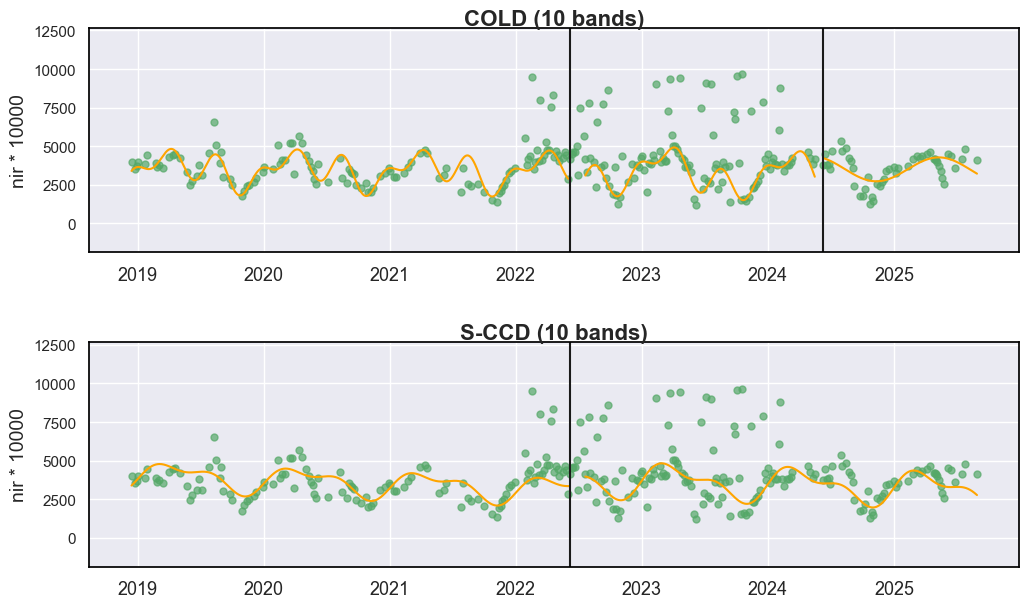

In [1]:
import numpy as np
import os
import pathlib
import pandas as pd
from dateutil import parser
# Imports from this package
from typing import List, Tuple, Dict, Union, Optional
from matplotlib.axes import Axes
import seaborn as sns
import matplotlib.pyplot as plt
from pyxccd import sccd_detect_flex, cold_detect_flex
from pyxccd.common import SccdOutput, cold_rec_cg
from pyxccd.utils import getcategory_sccd, defaults, getcategory_cold

def display_cold_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    cold_result: cold_rec_cg,
    axe: Axes,
    title: str = 'COLD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD algorithms,
    and visualizes the curve fitting and break detection results. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "COLD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])

    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0][band_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot COLD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot COLD segments
    for segment in cold_result:
        j = np.arange(segment['t_start'], segment['t_end'] + 1, 1)
        plot_df = pd.DataFrame({
            'dates': j,
            'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
            'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
            'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
            'trimodel': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index ][7]
        })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual'] + 
            plot_df['trimodel']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot breaks
    for i in range(len(cold_result)):
        if  cold_result[i]['change_prob'] == 100:
            if getcategory_cold(cold_result, i) == 1:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='k')
            else:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)
    


def display_sccd_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    for segment in sccd_result.rec_cg:
        j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
        if len(segment['coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': j * 0
            })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual']+
            plot_df['trimodal']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot near-real-time projection for SCCD if available
    if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
        recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
        j = np.arange(
            sccd_result.nrt_model['t_start_since1982'].item() + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
            recent_obs[-1].item()+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
            1
        )

        if len(sccd_result.nrt_model['nrt_coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': j * 0
            })
            
        plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot breaks
    for i in range(len(sccd_result.rec_cg)):
        if getcategory_sccd(sccd_result.rec_cg, i) == 1:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)



TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()

in_path = TUTORIAL_DATASET/ '3_crop_sentinel2.csv' # read the MPB-affected plot in CO

# read example csv for HLS time series
data = pd.read_csv(in_path)

# split the array by the column
Tile, B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, QA60 = data.to_numpy().copy().T

dates = np.array([parser.parse(tilename[0:8]).toordinal() for tilename in Tile])
qas = QA60.copy()

# Bit 10: Opaque clouds; Bit 11: Cirrus clouds
qas[qas>0] = 4

# for the flexible mode, we need to stack the chosen inputted bands into one array.
# Let's choose the bands with the resolution smaller than 60 meters. 
# B4 is green band, B12 is SWIR1, so they were chosen for tmask  (tmask_b1_index=3, tmask_b2_index=9).
sccd_result = sccd_detect_flex(dates.astype(np.int32), np.stack((B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12), axis=1).astype(np.int32), qas.astype(np.int32), lam=20, tmask_b1_index=3, tmask_b2_index=9)
cold_result = cold_detect_flex(dates.astype(np.int32), np.stack((B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12), axis=1).astype(np.int32), qas.astype(np.int32), lam=20, tmask_b1_index=3, tmask_b2_index=9)

            
# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_cold_result(data=np.stack((dates, B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12, qas), axis=1).astype(np.int64), band_names=['blues', 'green', 'red', 'edge1', 'edge2','edge3', 'nir', 'edge4', 'swir1', 'swir2'], band_index=6, cold_result=cold_result, axe=axes[0], title="COLD (10 bands)")

display_sccd_result(data=np.stack((dates, B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12, qas), axis=1).astype(np.int64), band_names=['blues', 'green', 'red', 'edge1', 'edge2','edge3', 'nir', 'edge4', 'swir1', 'swir2'], band_index=6, sccd_result=sccd_result, axe=axes[1], title="S-CCD (10 bands)")

Compared to the standard cold_detect and sccd_detect, the flexible versions (`cold_detect_flex` and `sccd_detect_flex`) require users to explicitly specify lambda and Tmask band indices:

(1) *Lambda*:
Users must provide a `lambda` value because different sensors may have different reflectance value ranges. If the input data is scaled to [0, 10000], we recommend using the default CCDC setting (`lambda=20`). In general, lambda should be scaled relative to the actual input range compared to the default Landsat range (10,000). For example, if the input range is [0, 20000], the new lambda will be 20 * 20000 / 10000 = 40.

(2) *Tmask band indices*:
In the standard functions, Tmask is hard-coded to use the Green and SWIR1 bands (i.e., `tmask_b1_index = 2`, `tmask_b2_index = 5` for Landsat). These bands are used to filter out cloud- or noise-affected observations from the temporal series. In the flexible mode, the band indices are exposed as user-defined parameters, since sensors such as Sentinel-2 or alternative preprocessed datasets may use different band orders.

## Trimodal S-CCD
In the above example, S-CCD shows a weaker fit compared to COLD, resulting a failure for detecting the second break that COLD detects due to the increased RMSE. The main reason for here is that this agricultural land has **two growing cycles per year**, while the standard S-CCD models seasonality with only two components (annual and semiannual), prioritizing computational efficiency and minimal storage. By contrast, COLD incorporates three components (annual, semiannual, and four-month cycles), which allows for more accurate fitting in cases with two growing seasons. To address this, the flexible mode of S-CCD provides a `trimodal` option, **enabling users to include the four-month cycle and achieve better curve fitting for cropland pixels**. 

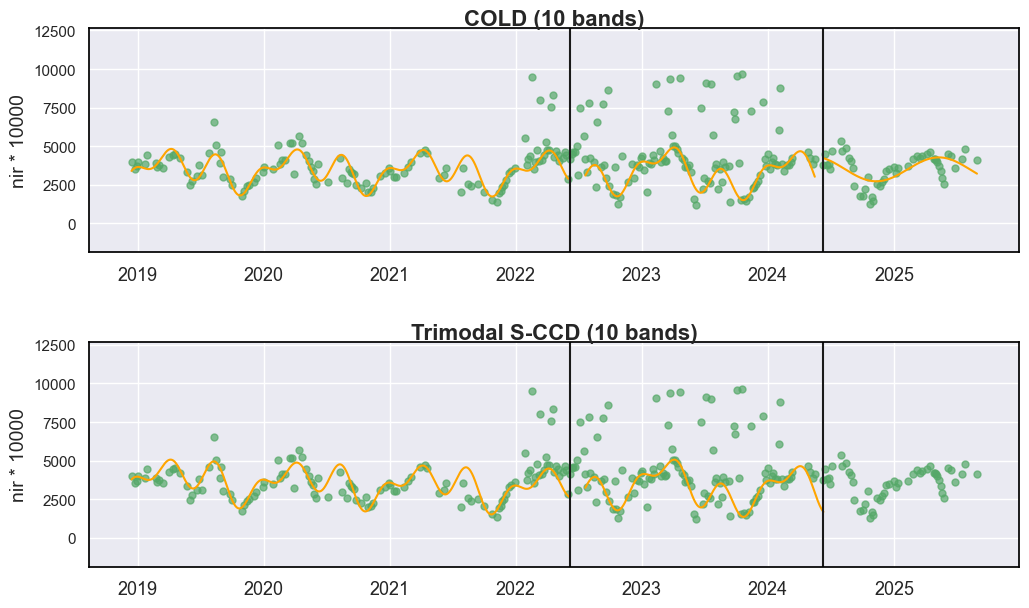

In [2]:
# enable trimodal
sccd_result = sccd_detect_flex(dates.astype(np.int32), np.stack((B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12), axis=1).astype(np.int32), qas.astype(np.int32), lam=20, tmask_b1_index=3, tmask_b2_index=9, trimodal=True)

            
# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

display_cold_result(data=np.stack((dates, B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12, qas), axis=1).astype(np.int64), band_names=['blues', 'green', 'red', 'edge1', 'edge2','edge3', 'nir', 'edge4', 'swir1', 'swir2'], band_index=6, cold_result=cold_result, axe=axes[0], title="COLD (10 bands)")

display_sccd_result(data=np.stack((dates, B2, B3, B4, B5, B6, B7, B8, B8A,  B11, B12, qas), axis=1).astype(np.int64), band_names=['blues', 'green', 'red', 'edge1', 'edge2','edge3', 'nir', 'edge4', 'swir1', 'swir2'], band_index=6, sccd_result=sccd_result, axe=axes[1], title="Trimodal S-CCD (10 bands)")

As shown above, the fitting curves produced by S-CCD and COLD are nearly identical, and both methods yielded the same break-detection results.

Next, we turn to the accuracy of the detected break. The time-series observations show an abrupt increase in fluctuation after 2022, which may be linked to human management activities. However, the second break detected in 2024 appears questionable, as no clear change signal can be identified from the time-series data. In this case, relying solely on all original Sentinel-2 spectral bands as inputs did not produce satisfactory break-detection performance. In the following section, we will examine whether combining spectral bands with vegetation indices can enhance the results.

## Inputting vegetation indices

The sentinel-2 MSI covering 13 spectral bands, which are denoted as:
| Sentinel-2 Bands| Central Wavelength | Resolution (m) |
| :------- | :------: | -------: |
| Band 1 -  Coastal aerosol  | 0.443  | 60    |
| Band 2 - Blue     | 0.490   | 10 |
| Band 3 - Green  | 0.560   | 10 |
| Band 4 - Red  | 0.665   | 10 |
| Band 5 - Red Edge  | 0.705   | 20 |
| Band 6 - Red Edge   | 0.740   | 20  |
| Band 7 - Red Edge   | 0.783   | 20  |
| Band 8 - NIR   | 0.842   | 10  |
| Band 8A - Red Edge   | 0.865   | 20  |
| Band 9 - Water vapour   | 0.945   | 60  |
| Band 10 - SWIR-Cirrus   | 1.375   | 60  |
| Band 11 - SWIR   | 1.610   | 20  |
| Band 12 - SWIR   | 2.190   | 20  |

For agricultural monitoring, the Enhanced Vegetation Index (EVI) is widely used to capture crop growth dynamics and vegetation physiological status. In this experiment, we selected five original Sentinel-2 spectral bands—green, red, NIR, SWIR1, and SWIR2—consistent with the standard CCDC configuration, and added one EVI band. These six variables were then used as the input features for both for `cold_detect_flex` and `sccd_detect_flex`:

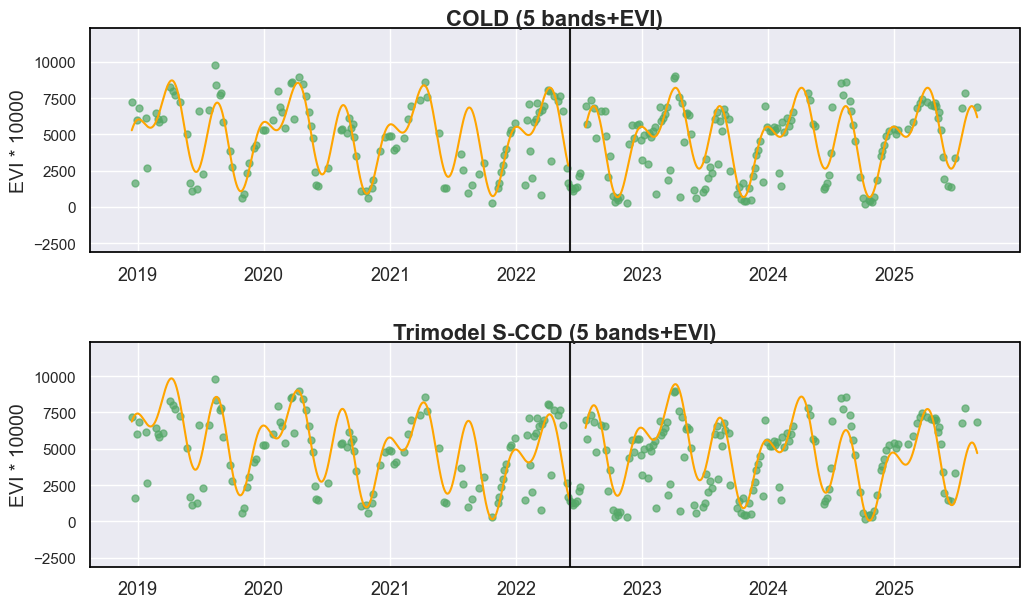

In [3]:
# scale EVI to [0, 10000]
evi = 25000 * (B8 - B4) / (B8 + 6.0 * B4 - 7.5 * B2 + 10000)

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


cold_result = cold_detect_flex(dates.astype(np.int32), np.stack((B3, B4, B8, B11, B12, evi), axis=1).astype(np.int32), qas.astype(np.int32), lam=20, tmask_b1_index=1, tmask_b2_index=4)

sccd_result = sccd_detect_flex(dates.astype(np.int32), np.stack((B3, B4, B8, B11, B12, evi), axis=1).astype(np.int32), qas.astype(np.int32), trimodal=True, lam=20, tmask_b1_index=1, tmask_b2_index=4)

display_cold_result(data=np.stack((dates, B3, B4, B8, B11, B12, evi, qas), axis=1).astype(np.int64), band_names=['green', 'red', 'nir',  'swir1', 'swir2', 'EVI'], band_index=5, cold_result=cold_result, axe=axes[0], title="COLD (5 bands+EVI)")

display_sccd_result(data=np.stack((dates, B3, B4, B8, B11, B12, evi, qas), axis=1).astype(np.int64), band_names=['green', 'red', 'nir',  'swir1', 'swir2', 'EVI'], band_index=5, sccd_result=sccd_result, axe=axes[1],  title="Trimodel S-CCD (5 bands+EVI)")


The spurious break detected in 2024 disappeared in this case for both algorithms, suggesting that **the inclusion of vegetation indices can improve the robustness of break detection**. This improvement likely arises because spectral indices enhance the consistency of the time series by mitigating atmospheric effects across individual bands. Both algorithms consistently identified a break in the summer of 2022, which is plausibly associated with **the cropland being left fallow in the autumn of 2021 (characterized by low EVI) and subsequently returning to active cultivation in 2022**. We therefore interpret this break as a valid detection of agricultural management alteration.

Lastly, we recommend incorporating EVI or NDVI as additional inputs for COLD or S-CCD to enhance cropland monitoring. Beyond improving the robustness of break detection, the fitted harmonic model (i.e., eight harmonic coefficients) from EVI or NDVI is highly valuable for characterizing cropping intensity, monitoring growth stages, and serving as a proxy for yield estimation. An application of the EVI harmonic model for crop phenology monitoring will be demonstrated in Lesson 9 (Phenology).